Moverse a lo largo del GRADIENTE

In [ ]:
from training.model import SIREN
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import meshplot as mp
import json

In [ ]:
FOLDER = 'segmented'
VERSION = ''
MESH = 'faust_54098'
RESULT = 'faust_54098'
EXPERIMENT = 'faust_54098'
MODEL = 'best'

dist = np.linspace(-1,1, 10)

with open(f'../data/{FOLDER}/{MESH}{VERSION}.json') as jsonFile:
    skel = json.load(jsonFile)
    features = len(skel['joints'][0]['mean'])
    model = SIREN(
            n_in_features= features + 3,
            n_out_features=1,
            hidden_layer_config=[256,256,256,256],
            w0=90,
            ww=None
    )
    model.to(torch.device(0))
    model.load_state_dict( torch.load(f'../results/{RESULT}/test_{EXPERIMENT}/models/model_{MODEL}.pth', map_location=torch.device(0)))
    model.eval()

    s= []
    for joint in skel['joints']:
        cantVertices = len(joint['vertices'])
        vertices_cpu = np.expand_dims( np.asarray( joint['vertices'] ), 0 )

        mean = torch.from_numpy( np.asarray( joint['mean'] ) ).repeat(1,cantVertices,1).float().to(torch.device(0))
        vertices = torch.from_numpy( vertices_cpu ).float().to(torch.device(0))

        x, y = model( torch.cat( ( mean, vertices), dim=2 ) ).values()
        df_pred = y
        df_pred.sum().backward()
        
        indexes = torch.tensor( [ features, features + 1, features + 2 ] ).to(torch.device(0))
        gradients = torch.index_select( x.grad, 2, indexes).detach()
        l = []
        for i in dist:
            x, y = model( torch.cat( (mean, vertices + gradients * torch.from_numpy(np.asarray(i)) ), dim=2) ).values()

            y = y.detach().cpu().numpy().squeeze(0)
            l.append(y)

        s.append(np.array(l))

In [ ]:
means = np.array([ np.mean(s[i], axis=1) for i in range(len(s))]).squeeze(2)

print( np.max(means),np.min(means))

In [ ]:
ax = sns.heatmap(means.T, yticklabels=[ f'{i:.2f}' for i in dist] )#, vmin=, vmax=1)
ax.tick_params(axis='y', rotation=0)
ax.set(xlabel="Submesh", ylabel="Peso gradiente")

Moverse a lo largo de la normal

In [1]:
from training.model import SIREN
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import meshplot as mp
import json

In [16]:
FOLDER = 'segmented'
VERSION = ''
MESH = 'faust_54098'
RESULT = 'faust_54098'
EXPERIMENT = 'faust_54098'
MODEL = 'best'
W0 = 60

dist = np.linspace(-2, 2, 30)

with open(f'../data/{FOLDER}/{MESH}{VERSION}.json') as jsonFile:
    skel = json.load(jsonFile)
    features = len(skel['joints'][0]['mean'])
    model = SIREN(
            n_in_features= features + 3,
            n_out_features=1,
            hidden_layer_config=[256,256,256,256],
            w0=W0,
            ww=None
    )
    model.to(torch.device(0))
    model.load_state_dict( torch.load(f'../results/{RESULT}/test_{EXPERIMENT}/models/model_{MODEL}.pth', map_location=torch.device(0)))
    model.eval()

    s= []
    for joint in skel['joints']:
        cantVertices = len(joint['vertices'])
        vertices_cpu = np.asarray( joint['vertices'] )
        normales_cpu = np.asarray( joint['normals'] )

        normales_cpu /= np.mean( np.linalg.norm( normales_cpu, axis=1 ))

        mean = torch.from_numpy( np.asarray( joint['mean'] ) ).repeat(1,cantVertices,1).float().to(torch.device(0))
        vertices = torch.from_numpy( np.expand_dims(vertices_cpu, 0) ).float().to(torch.device(0))
        normales = torch.from_numpy( np.expand_dims(normales_cpu, 0) ).float().to(torch.device(0))

        l = []
        for i in dist:
            x, y = model( torch.cat( (mean, vertices + normales * torch.from_numpy(np.asarray(i)) ), dim=2) ).values()

            y = y.detach().cpu().numpy().squeeze(0)
            l.append(y)

        s.append(np.array(l))

In [17]:
means = np.array([ np.mean(s[i], axis=1) for i in range(len(s))]).squeeze(2)

print( np.max(means),np.min(means))

1.960959 -0.08534425


[Text(0.5, 23.52222222222222, 'Submesh'),
 Text(50.722222222222214, 0.5, 'Peso gradiente')]

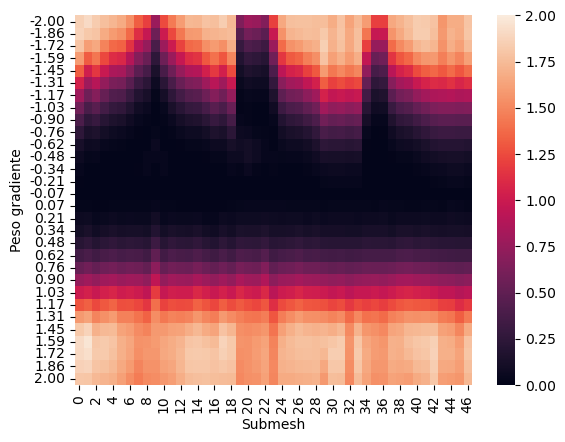

In [18]:
ax = sns.heatmap(means.T, yticklabels=[ f'{i:.2f}' for i in dist], vmin=0, vmax=2 )
ax.tick_params(axis='y', rotation=0)
ax.set(xlabel="Submesh", ylabel="Peso gradiente")